# Imports

In [1]:
!pip install kora -q
import kora.install.rdkit
!pip install deepchem
!pip install fcd
!pip install SmilesPE

     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 552kB 14.5MB/s 
     |████████████████████████████████| 53.1MB 86kB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import rdkit
from SmilesPE.pretokenizer import atomwise_tokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import tqdm
from sklearn.model_selection import train_test_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Ignore some warnings from RDKIT
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 

import warnings
warnings.filterwarnings("ignore")

# Load methods from the FCD library
from fcd import get_fcd, load_ref_model, canonical_smiles, get_predictions, calculate_frechet_distance

np.random.seed(1234)

# For CUDA debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("RDKit: ", rdkit.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RDKit:  2020.09.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/ails_challenge_2/'

# Utility Functions

In [63]:
def plot_metrics(train_errors, valid_errors):
  x = np.arange(1, len(train_errors)+1)
  fig = plt.figure(figsize=(20,5))
  ax = fig.add_subplot(131, label="train")
  ax.plot(x, train_errors, color="C0", label="training loss")
  ax.plot(x, valid_errors, color="C1", label="validation loss")
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epoch")        
  ax.xaxis.grid(False)  
  ax.legend()

  plt.show()

In [6]:
def save_checkpoint(model, optimiser, epoch, loss, dictionary):
  """Saves a model checkpoint"""
  state = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimiser_state_dict': optimiser.state_dict(),
      'loss': loss,
      'dict': dictionary
  }
  os.makedirs(path + "checkpoints", exist_ok=True)
  ckp_name = f'checkpoint-epoch{epoch}.pth'
  filename = os.path.join(path + "checkpoints", ckp_name)
  torch.save(state, filename)

In [43]:
def load_checkpoint(model, optimiser, epoch):
  ckp_name = f'checkpoint-epoch{epoch}.pth'
  filename = os.path.join(path + "checkpoints", ckp_name)

  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
  loss = checkpoint['loss']
  dictionary = checkpoint['dict']
  return model, optimiser, loss, dictionary

# Preprocessing

In [8]:
def load_data(file_path):
  with open(file_path, 'r', encoding="utf-8") as file:
    data = file.read()
  return data

def get_dictionary(data, atom):
  if atom:
    characters = [pad_token, start_token, end_token] + list(set(atomwise_tokenizer(data)))
  else:
    characters = [pad_token, start_token, end_token] + sorted(list(set(data)))

  char2idx = dict((c, i) for i, c in enumerate(characters))
  idx2char = dict((i, c) for i, c in enumerate(characters))
  dictionary = (char2idx, idx2char)
  return dictionary, characters

def preprocess(data):  
  smiles = data.split() # separate string into distinct smiles molecules
  smiles_can = canonical_smiles(smiles)  # canonicalize
  smiles_can = list(filter(None, smiles_can))  # filter invalid ones
  preprocessed_smiles = add_tokens(smiles_can)
  return preprocessed_smiles

def add_tokens(smiles):
  smiles_new = []
  for smile in smiles:
    smiles_new.append(start_token + smile + end_token)
  return smiles_new

def encode(smiles, dictionary, atom):
  char2idx = dictionary[0]
  if atom:
    encoded = []
    for smile in smiles:
      token = atomwise_tokenizer(smile)
      if len(token) > 1:
        tokenized = [1]
        for s in token:    
          tokenized.append(char2idx[s])
        tokenized.append(2)
        encoded.append(torch.Tensor(tokenized).long())
  else:
    encoded = [torch.Tensor([char2idx[s] for s in smile]).long() for smile in smiles]
  lengths = [len(smile_enc)-1 for smile_enc in encoded]
  return encoded, lengths

def get_padded_tensor(encoded, n_max):
  dummy = [torch.zeros(n_max)]  # to ensure that train and validation get the same padding size
  padded = pad_sequence(dummy + encoded, batch_first=True, padding_value=0)
  padded = padded[1:]  # omit the dummy
  return padded

atom = True  # whether to use atomwise tokenizer

pad_token = 'x'
start_token = 'y'
end_token = 'z'

data = load_data(path + 'smiles_train.txt')
smiles = preprocess(data)
dictionary_data = " ".join(smiles)
dictionary, characters = get_dictionary(dictionary_data, atom=atom)

n_max = len(max(smiles, key=len))

# train test split
smiles_train, smiles_val = train_test_split(smiles, test_size=0.3, random_state=42)

encoded_train, lengths_train = encode(smiles_train, dictionary, atom=atom)
encoded_val, lengths_val = encode(smiles_val, dictionary, atom=atom)

tensor_train = get_padded_tensor(encoded_train, n_max)
tensor_val = get_padded_tensor(encoded_val, n_max)

In [9]:
class Data(Dataset):
  def __init__(self, embedded, encoded, lengths):  
    self.embedded = embedded
    self.encoded = encoded
    self.lengths = lengths
    self.samples = self.__create_samples() 

  def __get_tuple(self, idx):
    data = self.embedded[idx,:]
    x = data[0:-1]
    y = data[1:]
    len = self.lengths[idx]
    return (x, y, len)

  def __create_samples(self):
    samples = [self.__get_tuple(idx) for idx in range(self.embedded.shape[0])]
    return samples
        
  def __len__(self) -> int:
    return len(self.samples)
      
  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    return self.samples[idx]

In [10]:
train_set = Data(tensor_train.long(), encoded_train, lengths_train)
val_set = Data(tensor_val.long(), encoded_val, lengths_val)

# Network

In [12]:
class MoleculeGenerator(nn.Module):
  def __init__(self, n_in, n_hidden, n_out, n_seq, n_layers=1, dropout_rate=0.3):
    super(MoleculeGenerator, self).__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.n_out = n_out
    self.n_seq = n_seq

    self.embedding = nn.Embedding(n_out, n_in, padding_idx=0)
    self.lstm = nn.LSTM(input_size=n_in, hidden_size=n_hidden, num_layers=n_layers, dropout=dropout_rate, batch_first=True)
    self.out = nn.Linear(n_hidden, n_out)

  def forward(self, input, hidden, lengths=None):
    input = self.embedding(input)
    if lengths is not None:
      input = pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
    output, hidden = self.lstm(input, hidden)
    if lengths is not None:
      output, _ = pad_packed_sequence(output, batch_first=True, total_length=self.n_seq)
    output = output.contiguous().view(-1, self.n_hidden)
    output = self.out(output)
    return output, hidden

  def init_hidden(self, batch_size):
    hidden=(Variable(torch.zeros(self.n_layers, batch_size, self.n_hidden)),
            Variable(torch.zeros(self.n_layers, batch_size, self.n_hidden)))
    return hidden


In [13]:
def get_error(network, dataloader, loss):
  for x, y, len in dataloader:
    x, y = x.to(device), y.to(device)

    batch_size = x.size(0)
    sequence_length = x.size(1)

    hidden = network.init_hidden(batch_size)
    hidden = (hidden[0].to(device), hidden[1].to(device))
    
    y_pred, hidden = network(x, hidden, lengths=None)
    err = loss(y_pred, y.view(batch_size * sequence_length))
    del(x, y)
    yield err

In [38]:
@torch.no_grad()
def evaluate(network, loss, dataloader, epoch):

  network.eval()
  errors = []

  with tqdm(get_error(network, dataloader, loss), leave=True, unit=" batches", position=0, total=len(dataloader)) as pbar:
    n_batches = len(pbar)
    for i, err in enumerate(pbar):
      pbar.set_description('epoch {}: validation loss {}'.format(epoch, round(err.item(), 4)))
      errors.append(err.item())

      if i == n_batches-1:
        mean_err = sum(errors) / len(errors)
        pbar.set_description('epoch {}: mean validation loss {}'.format(epoch, round(mean_err, 4)))
  pbar.close()
  return mean_err

In [39]:
@torch.enable_grad()
def update(network, loss, dataloader, opt, epoch):
  network.train()
  errors = []

  with tqdm(get_error(network, dataloader, loss), leave=True, unit=" batches", position=0, total=len(dataloader)) as pbar:
    n_batches = len(pbar)
    for i, err in enumerate(pbar):
      network.zero_grad()
      err.backward()
      opt.step()

      pbar.set_description('epoch {}: training loss {}'.format(epoch, round(err.item(), 4)))
      errors.append(err.item())

      if i == n_batches-1:
        mean_err = sum(errors) / len(errors)
        pbar.set_description('epoch {}: mean training loss {}'.format(epoch, round(mean_err, 4)))

  pbar.close()
  return mean_err

# Training

In [59]:
# Parameters
n_in = len(characters)  # embedding size
n_hidden = 1000
n_out = len(characters)  # number of characters
n_layers = 2
batch_size = 256
shuffle = True
epochs = 21
lr = 1e-4
n_seq = n_max-1

In [60]:
train_errors = []
valid_errors = []

# Data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
valid_loader = DataLoader(val_set, batch_size=batch_size)
    
# Network, Loss and Optimiser
network = MoleculeGenerator(n_in, n_hidden, n_out, n_seq, n_layers)
network = network.to(device)
loss = nn.CrossEntropyLoss(ignore_index=0)
optimiser = torch.optim.Adam(network.parameters(), lr=lr)  

for epoch in range(epochs):
  if epoch is 0:
    pass  # skip initial validation to speed up training
    # train_errors = [evaluate(network, loss.eval(), train_loader, epoch)]
    # valid_errors = [evaluate(network, loss.eval(), valid_loader, epoch)]
  else:
    train_error = update(network, loss, train_loader, optimiser, epoch)
    train_errors.append(train_error)
    valid_error = evaluate(network, loss.eval(), valid_loader, epoch)
    valid_errors.append(valid_error)
    save_checkpoint(network, optimiser, epoch, loss, dictionary)  

epoch 20: mean validation loss 0.5064: 100%|██████████| 1492/1492 [01:50<00:00, 13.47 batches/s]


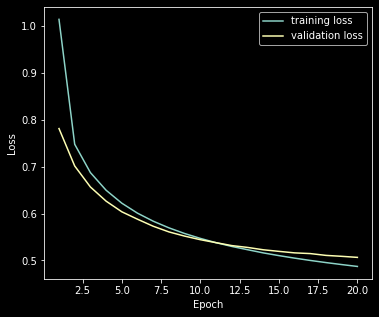

In [64]:
plot_metrics(train_errors, valid_errors)

# Generate SMILES

Source of generation code: https://medium.com/@sunitachoudhary103/generating-molecules-using-a-char-rnn-in-pytorch-16885fd9394b

In [126]:
# Declaring a method to generate new text
def sample(net, primes, size, dictionary, top_k=None):
  net.eval() # eval mode  
  hidden = net.init_hidden(1)
  char2idx = dictionary[0]

  prime = random.sample(primes, 1)[0]
  chars = [ch for ch in prime]
  x = np.ones((1,1))  # start token
  idx, char, hidden = predict(net, x, hidden, dictionary, top_k=top_k)
  for ch in atomwise_tokenizer(prime):
    x = np.array([[char2idx[ch]]])
    idx, char, hidden = predict(net, x, hidden, dictionary, top_k=top_k)
  chars.append(char)

  # Now pass in the previous character and get a new one
  for ii in range(size):
      idx = np.expand_dims(np.expand_dims(np.array(idx), axis=0), axis=0)
      idx, char, hidden = predict(net, idx, hidden, dictionary, top_k=top_k)
      if idx == 2:
        break    
      chars.append(char)
  return ''.join(chars)

In [127]:
def predict(net, x, h, dictionary, top_k=None):
  ''' Given a character, predict the next character.
      Returns the predicted character and the hidden state.
  '''
  idx2char = dictionary[1]
  # tensor inputs
  x = torch.from_numpy(x).long()
  x = x.to(device)
  # detach hidden state from history
  h = tuple([each.data.to(device) for each in h])
  # get the output of the model
  out, h = net(x, h)
  p = F.softmax(out, dim=1).data
  p = p.cpu() # move to cpu
  # get top characters
  if top_k is None:
      top_ch = np.arange(len(characters))
  else:
      p, top_ch = p.topk(top_k)
      top_ch = top_ch.numpy().squeeze()
  # select the likely next character with some element of randomness
  p = p.numpy().squeeze()
  idx = np.random.choice(top_ch, p=p/p.sum())
  # convert idx to char
  char = idx2char[idx]
  return idx, char, h

In [128]:
n_smiles = 11000
generated_smiles = []

# Get prime characters from train data
primes = [smile[1:3] for smile in smiles]

for i in range(n_smiles):
  generated_smiles.append(sample(network, primes, n_max, dictionary, top_k=4))

In [129]:
generated_smiles[:10]

['COc1cc(CC(=O)NCC(=O)NC(Cc2ccccc2)C(=O)NC(C=Cc2ccccc2)C(=O)O)cc(OC)c1OC',
 'CCCCCNCC(O)COc1cccc(O)c1',
 'CC(=O)OC1CCC2(C)C(CCC3(C)C2C(=O)C=C2C4C(C)C(C)CCC4(C(=O)N4CCN(Cc5ccccc5)CC4)CCC23)CC1(C)C',
 'N=C(N)Nc1ccc(C(=O)OCC(=O)NC2CCC(=O)NC2)cc1',
 'COC(=O)NC(C(=O)NN(CCC(O)(Cc1ccccc1)C(=O)NC1c2ccccc2CC1O)Cc1ccc(-c2ccsc2)cc1)C(C)(C)C',
 'COc1ccc(N(CC(=O)NCCCN2CCN(c3ccccn3)CC2)S(C)(=O)=O)cc1',
 '[O=C(O)CCCC(=O)Nc1ccc(-c2nc3ccccc3c(=O)[nH]2)cc1',
 'Cc1csc(NC(=O)CCNS(=O)(=O)c2ccc(C)cc2)n1',
 'COc1cc(C2CCN(C)CC2)ccc1Nc1ncc2c(n1)N(C)c1ccc(Cl)cc1C(=O)N2C',
 'Cc1nn(C)c(C)c1N[S+](=O']

# Export valid generated SMILES

In [130]:
smiles_gen_can = [w for w in canonical_smiles(generated_smiles) if w is not None]
print('Nr of valid smiles: ' + str(len(smiles_gen_can)))

Nr of valid smiles: 10469


In [84]:
with open(path + "submission.txt", "w") as smiles_file:
  smiles_file.write("\n".join(smiles_gen_can))

# Check Metrics

In [131]:
smiles_gen = smiles_gen_can.copy()[:10000]
smiles_gen_can = [w for w in canonical_smiles(smiles_gen) if w is not None]

# Calculate statistics for the sample submission
model = load_ref_model()
act_gen = get_predictions(model, smiles_gen_can)
mu_gen = np.mean(act_gen, axis=0)
sigma_gen = np.cov(act_gen.T)

# Load precomputed test mean and covariance
with open(path + "resources/test_stats.p", 'rb') as f:
    mu_test, sigma_test = pickle.load(f)

fcd_value = calculate_frechet_distance(
    mu1=mu_gen,
    mu2=mu_test,
    sigma1=sigma_gen,
    sigma2=sigma_test)
print('FCD: ', fcd_value)

validity = len(smiles_gen_can) / len(smiles_gen)
print("Validity: ", validity)

smiles_unique = set(smiles_gen_can)
uniqueness = len(smiles_unique) / len(smiles_gen)
print("Uniqueness: ", uniqueness)

# load training set for novelty
with open(path + "smiles_train.txt") as f:
    smiles_train = {s for s in f.read().split() if s}

smiles_novel = smiles_unique - smiles_train
novelty = len(smiles_novel) / len(smiles_gen)
print("Novelty: ", novelty)

FCD:  0.6926020565041426
Validity:  1.0
Uniqueness:  0.9987
Novelty:  0.9229


## Load Checkpoint and proceed with training

In [56]:
model = MoleculeGenerator(n_in, n_hidden, n_out, n_seq, n_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)   
model, optimiser, _, dictionary = load_checkpoint(model, optimiser, epoch=10)
model = model.to(device)

In [ ]:
for epoch in range(21, 31):
  train_error = update(model, loss, train_loader, optimiser, epoch)
  train_errors.append(train_error)
  valid_error = evaluate(model, loss.eval(), valid_loader, epoch)
  valid_errors.append(valid_error)
  save_checkpoint(model, optimiser, epoch, loss, dictionary)         